#Data Helper

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
workfolder = "MyDrive/HumanLLMTextAnswerAgg/Gemini/"
folder = "data/"

import os
os.chdir('/content/drive')
os.chdir(workfolder)
!ls

In [30]:
import pandas as pd
import numpy as np

def loaddata(labelfilename,gtfilename):
  gtdf = pd.read_csv(gtfilename,sep='\t',encoding='utf-8')

  sentences = gtdf['sentence'].values.tolist()
  truelabels = {}
  for idx,row in gtdf.iterrows():
    truelabels[row['sentence']] = row['trueanswer']

  labeldf = pd.read_csv(labelfilename,sep='\t',encoding='utf-8')

  workers = []
  swlabels = []

  for idx,row in labeldf.iterrows():
    worker = row['worker']
    if worker not in workers:
      workers.append(worker)
    workerid = workers.index(worker)
    sentenceid = sentences.index(row['sentence'])
    label = row['workeranswer'].strip()
    swlabels.append((sentenceid,workerid,label))

  return (workers,sentences,swlabels,truelabels)

def labelformatconversion(workers,sentences,swlabels):
  wlabelidlists = {}
  wsentenceidlists = {}
  for worker in workers:
    wlabelidlists[worker] = []
    wsentenceidlists[worker] = []

  slabelidlists = {}
  sworkeridlists = {}
  for sentence in sentences:
    slabelidlists[sentence] = []
    sworkeridlists[sentence] = []

  labellist = []
  labelidx = 0
  for (sentenceid,workerid,label) in swlabels:
    labellist.append(label)
    sentence = sentences[sentenceid]
    slabelidlists[sentence].append(labelidx)
    sworkeridlists[sentence].append(workerid)
    worker = workers[workerid]
    wlabelidlists[worker].append(labelidx)
    wsentenceidlists[worker].append(sentenceid)
    labelidx += 1

  return (labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists)

def truelabelformatonversion(sentences,truelabels):
  truelabellist = []
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabellist.append(truelabels[sentence])

  return truelabellist

# Universal Sentence Encoder

In [ ]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install --quiet seaborn

In [ ]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_hub as hub
import os
import re
print('TensorFlow version:', tf.__version__)
print('TensorFlow Hub version:', hub.__version__)

Instructions for updating:
non-resource variables are not supported in the long term


TensorFlow version: 2.15.0
TensorFlow Hub version: 0.16.1


In [ ]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

# Evaluation Method

In [ ]:
DEFAULT_SIM_TYPE = 'COSINE'
def similarity(embed1, embed2, simtype = DEFAULT_SIM_TYPE):
  if (simtype == 'COSINE'):
    l1 = np.sqrt(np.sum(embed1**2))
    l2 = np.sqrt(np.sum(embed2**2))
    sim = np.inner(embed1,embed2) / (l1*l2)

  return sim

## Embedding

In [ ]:
def evaluationbyEmbedding(sentences, elabels, label_embeddings, truelabels, truelabel_embeddings):
  totalsim = 0
  for sentence in elabels:
    elabel_embedding = label_embeddings[elabels[sentence]]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    totalsim += similarity(elabel_embedding,truelabel_embedding)

  #print(len(elabels),totalsim/len(elabels))
  return totalsim/len(elabels)


## GLEU

In [ ]:
import nltk
import nltk.translate.gleu_score as gleu

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')

def evaluationbyGLEU(sentences, labels, elabelidxs, truelabels):
  n = len(sentences)
  sim = 0
  for i in range(n):
    sentence = sentences[i]
    labelidx = elabelidxs[sentence]
    label = labels[labelidx]
    truelabel = truelabels[sentence]
    sim += gleu.sentence_gleu([truelabel.split()], label.split())
  #print(n,sim/n)
  return sim/n

## METEOR

In [ ]:
import nltk
import nltk.translate.meteor_score as meteor

try:
  nltk.data.find('tokenizers/punkt')
except LookupError:
  nltk.download('punkt')

try:
  nltk.data.find('wordnet')
except LookupError:
  nltk.download('wordnet')

def evaluationbyMETEOR(sentences, labels, elabelidxs, truelabels):
  n = len(sentences)
  sim = 0
  for i in range(n):
    sentence = sentences[i]
    labelidx = elabelidxs[sentence]
    label = labels[labelidx]
    truelabel = truelabels[sentence]
    sim += meteor.meteor_score([truelabel.split()], label.split())
  #print(n,sim/n)
  return sim/n

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Methods

## SMV

In [ ]:
def SMVSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    onetotal_sim = 0
    for label_embedding in slabel_embeddings:
      onetotal_sim += similarity(label_embedding,truelabel_embedding)
    total_sim += onetotal_sim/len(slabel_embeddings)

  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def SMVSelectionAndEvaluationbyGLEU(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    onetotal_sim = 0
    for label in slabels:
      onetotal_sim += gleu.sentence_gleu([truelabel.split()], label.split())
    total_sim += onetotal_sim/len(slabels)

  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def SMVSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    onetotal_sim = 0
    for label in slabels:
      onetotal_sim += meteor.meteor_score([truelabel.split()], label.split())
    total_sim += onetotal_sim/len(slabels)

  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

##SMS

In [ ]:
def SMSSelectionOne(labelidlist, slabel_embeddings):
  labelnum = len(slabel_embeddings)
  simmat = np.zeros((labelnum,labelnum))
  for i in range(labelnum):
    for j in range(labelnum):
      simmat[i][j] = similarity(slabel_embeddings[i],slabel_embeddings[j])

  sim = np.sum(simmat,axis=1)
  maxlabelidx = np.argmax(sim)
  return labelidlist[maxlabelidx]

def SMSSelection(sentences, slabelidlists, label_embeddings):
  elabels = {}
  for i in range(len(sentences)):
    sentence = sentences[i]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    elabel = SMSSelectionOne(slabelidlists[sentence], slabel_embeddings)
    elabels[sentence] = elabel
  return elabels

## RASA

In [ ]:
from scipy.stats import chi2

def RASAInference(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, label_embeddings):
  max_ite = 1000

  # initilizing the estimated embedding by using SMV
  estimated_embeddings = []
  for i in range(len(sentences)):
    sentence = sentences[i]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    estimated_embeddings.append(np.mean(slabel_embeddings, axis=0))
  estimated_embeddings = np.asarray(estimated_embeddings)

  w_num = len(workers)
  reliability = np.zeros(w_num)
  s_num = len(sentences)

  ite = 0
  eb_change = 1
  while (ite <= max_ite) and (eb_change > 0.0000001):
    old_estimated_embeddings = np.copy(estimated_embeddings)

    # compute reliability
    for j in range(w_num):
      worker = workers[j]
      westimated_embeddings = estimated_embeddings[wsentenceidlists[worker]]
      nw = len(wsentenceidlists[worker])
      chiw = chi2.isf(q=0.025, df=nw)
      wlabelidlist = wlabelidlists[worker]
      wlabel_embeddings = label_embeddings[wlabelidlist]
      diff_embedding = (westimated_embeddings - wlabel_embeddings)
      if (np.sum(diff_embedding) == 0):
        reliability[j] = 1
      else:
        reliability[j] = chiw / np.sum(diff_embedding*diff_embedding)

    # compute estimated embeddings
    for i in range(s_num):
      sentence = sentences[i]
      slabelidlist = slabelidlists[sentence]
      slabel_embeddings = label_embeddings[slabelidlist]
      sworkeridlist = sworkeridlists[sentence]
      sworkeridrelaiblity = reliability[sworkeridlist]
      for j in range(len(sworkeridrelaiblity)):
        slabel_embeddings[j] = slabel_embeddings[j] * sworkeridrelaiblity[j]
      estimated_embeddings[i] = np.sum(slabel_embeddings, axis=0) / np.sum(sworkeridrelaiblity)

    eb_diff = (estimated_embeddings - old_estimated_embeddings)
    eb_change = np.sum(eb_diff * eb_diff)
    ite += 1

  return (estimated_embeddings,reliability)

def RASASelectionOne(estimated_embedding, labelidlist, label_embeddings):
  slabel_num = len(labelidlist)
  slabel_embeddings = label_embeddings[labelidlist]
  simvec = np.zeros(slabel_num)
  for k in range(slabel_num):
    simvec[k] = similarity(estimated_embedding,slabel_embeddings[k])
  maxlabelidx = np.argmax(simvec)
  return labelidlist[maxlabelidx]

def RASASelection(sentences, slabelidlists, label_embeddings, estimated_embeddings):
  elabels = {}
  for i in range(len(sentences)):
      sentence = sentences[i]
      slabelidlist = slabelidlists[sentence]
      elabel = RASASelectionOne(estimated_embeddings[i], slabelidlist, label_embeddings)
      elabels[sentence] = elabel
  return elabels

##Optimal

In [ ]:
def OptimalSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel_embedding = truelabel_embeddings[sentences.index(sentence)]
    slabel_embeddings = label_embeddings[slabelidlists[sentence]]
    ns = len(slabel_embeddings)
    sims = np.zeros(ns)
    for k in range(ns):
      label_embedding = slabel_embeddings[k]
      sims[k] = similarity(label_embedding,truelabel_embedding)
    maxsim = np.max(sims)
    total_sim += maxsim
  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def OptimalSelectionAndEvaluationbyGLEU(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    ns = len(slabels)
    sims = np.zeros(ns)
    for k in range(ns):
      label = slabels[k]
      sims[k] = gleu.sentence_gleu([truelabel.split()], label.split())
    maxsim = np.max(sims)
    total_sim += maxsim
  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

In [ ]:
def OptimalSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, labels, truelabels):
  total_sim = 0
  for i in range(len(sentences)):
    sentence = sentences[i]
    truelabel = truelabels[sentences.index(sentence)]
    slabels = labels[slabelidlists[sentence]]
    ns = len(slabels)
    sims = np.zeros(ns)
    for k in range(ns):
      label = slabels[k]
      sims[k] = meteor.meteor_score([truelabel.split()], label.split())
    maxsim = np.max(sims)
    total_sim += maxsim
  #print(len(sentences),total_sim/len(sentences))
  return total_sim/len(sentences)

#Experiments

In [ ]:
def run(labelfilename,gtfilename):
  # labellist: all labels for all sentences by all workers
  # slabelidlists: label id list for each sentence
  # sworkeridlists: worker id list for each sentence
  # wlabelidlists: label id list for each worker
  # wsentenceidlists: sentence id list for each worker
  (workers,sentences,swlabels,truelabels) = loaddata(labelfilename,gtfilename)
  (labellist,slabelidlists,sworkeridlists,wlabelidlists,wsentenceidlists) = labelformatconversion(workers,sentences,swlabels)
  (truelabellist) = truelabelformatonversion(sentences,truelabels)

  # label_embeddings: embeddings of all labels of workers
  # truelabel_embeddings: embeddings of all true labels

  # Import the Universal Sentence Encoder's TF Hub module
  #embed = hub.Module(module_url)
  embed = hub.load(module_url)

  # Reduce logging output.
  tf.logging.set_verbosity(tf.logging.ERROR)

  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    label_embeddings = session.run(embed(labellist))

  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    truelabel_embeddings = session.run(embed(truelabellist))

  # print('Optimal')
  perf_opt_embedding = OptimalSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings)
  perf_opt_gleu = OptimalSelectionAndEvaluationbyGLEU(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))
  perf_opt_meteor = OptimalSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))

  # print('SMV')
  perf_smv_embedding = SMVSelectionAndEvaluationbyEmbedding(sentences, slabelidlists, label_embeddings, truelabel_embeddings)
  perf_smv_gleu = SMVSelectionAndEvaluationbyGLEU(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))
  perf_smv_meteor = SMVSelectionAndEvaluationbyMETEOR(sentences, slabelidlists, np.asarray(labellist), np.asarray(truelabellist))


  # print('SMS')
  LSNNelabels = SMSSelection(sentences, slabelidlists, label_embeddings)
  perf_sms_embedding = evaluationbyEmbedding(sentences, LSNNelabels, label_embeddings, truelabels, truelabel_embeddings)
  perf_sms_gleu = evaluationbyGLEU(sentences, np.asarray(labellist), LSNNelabels, truelabels)
  perf_sms_meteor = evaluationbyMETEOR(sentences, np.asarray(labellist), LSNNelabels, truelabels)

  # print('RASA')
  (estimated_embeddings, reliability) = RASAInference(workers, sentences, slabelidlists, sworkeridlists, wlabelidlists, wsentenceidlists, label_embeddings)
  LSCATDelabels = RASASelection(sentences, slabelidlists, label_embeddings, estimated_embeddings)
  perf_rasa_embedding = evaluationbyEmbedding(sentences, LSCATDelabels, label_embeddings, truelabels, truelabel_embeddings)
  perf_rasa_gleu = evaluationbyGLEU(sentences, np.asarray(labellist), LSCATDelabels, truelabels)
  perf_rasa_meteor = evaluationbyMETEOR(sentences, np.asarray(labellist), LSCATDelabels, truelabels)

  print("Evaluation,SMV,SMS,RASA,Optimal")
  print("Embedding,%.4f,%.4f,%.4f,%.4f" % (perf_smv_embedding,perf_sms_embedding,perf_rasa_embedding,perf_opt_embedding))
  print("GLEU,%.4f,%.4f,%.4f,%.4f" % (perf_smv_gleu,perf_sms_gleu,perf_rasa_gleu,perf_opt_gleu))
  print("METEOR,%.4f,%.4f,%.4f,%.4f" % (perf_smv_meteor,perf_sms_meteor,perf_rasa_meteor,perf_opt_meteor))

## Crowd Only

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.6732,0.7426,0.7414,0.8475
GLEU,0.1930,0.2489,0.2537,0.4990
METEOR,0.3861,0.4666,0.4745,0.7077


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7245,0.7935,0.8020,0.8750
GLEU,0.1740,0.2310,0.2376,0.3698
METEOR,0.3786,0.4548,0.4718,0.6073


In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7105,0.7860,0.7935,0.8669
GLEU,0.1616,0.2189,0.2340,0.3637
METEOR,0.3604,0.4426,0.4653,0.6034


## HumanAgg Only

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.6983,0.7360,0.7162,0.7963
GLEU,0.2260,0.2740,0.2397,0.3835
METEOR,0.4397,0.4912,0.4524,0.6200


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7430,0.7851,0.7761,0.8278
GLEU,0.1819,0.2074,0.2007,0.2827
METEOR,0.3927,0.4330,0.4272,0.5198


In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7282,0.7681,0.7468,0.8145
GLEU,0.1769,0.2087,0.1952,0.2963
METEOR,0.3746,0.4238,0.4083,0.5315


## Gemini Only

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_9temperature_trial0_gemini-1.5-pro-latest.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7339,0.7435,0.7418,0.7884
GLEU,0.2693,0.2833,0.2819,0.3663
METEOR,0.5000,0.5167,0.5122,0.6113


1temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7265,0.7265,0.7265,0.7265

GLEU,0.2588,0.2588,0.2588,0.2588

METEOR,0.4869,0.4869,0.4869,0.4869

3temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7289,0.7278,0.7265,0.7528

GLEU,0.2633,0.2570,0.2588,0.3099

METEOR,0.4926,0.4894,0.4869,0.5466

5temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7310,0.7313,0.7311,0.7735

GLEU,0.2661,0.2623,0.2626,0.3441

METEOR,0.4954,0.4925,0.4885,0.5829

7temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7337,0.7391,0.7315,0.7819

GLEU,0.2681,0.2761,0.2635,0.3522

METEOR,0.4988,0.5105,0.4919,0.5942

9temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7339,0.7435,0.7418,0.7884

GLEU,0.2693,0.2833,0.2819,0.3663

METEOR,0.5000,0.5167,0.5122,0.6113


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_9temperature_trial0_gemini-1.5-pro-latest.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7625,0.7758,0.7711,0.8045
GLEU,0.2099,0.2282,0.2224,0.2638
METEOR,0.4270,0.4467,0.4383,0.4926


1temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7577,0.7577,0.7577,0.7577

GLEU,0.1968,0.1968,0.1968,0.1968

METEOR,0.4165,0.4165,0.4165,0.4165

3temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7593,0.7638,0.7577,0.7804

GLEU,0.2015,0.2039,0.1968,0.2216

METEOR,0.4218,0.4303,0.4165,0.4511

5temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7635,0.7698,0.7701,0.7998

GLEU,0.2082,0.2136,0.2126,0.2559

METEOR,0.4258,0.4364,0.4392,0.4841

7temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7645,0.7728,0.7719,0.8019

GLEU,0.2112,0.2221,0.2221,0.2591

METEOR,0.4283,0.4370,0.4389,0.4878

9temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7625,0.7758,0.7711,0.8045

GLEU,0.2099,0.2282,0.2224,0.2638

METEOR,0.4270,0.4467,0.4383,0.4926

In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_9temperature_trial0_gemini-1.5-pro-latest.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7590,0.7709,0.7689,0.8072
GLEU,0.1898,0.2009,0.2002,0.2486
METEOR,0.4034,0.4180,0.4218,0.4898


1temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7458,0.7458,0.7458,0.7458

GLEU,0.1736,0.1736,0.1736,0.1736

METEOR,0.3805,0.3805,0.3805,0.3805

3temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7475,0.7479,0.7458,0.7701

GLEU,0.1751,0.1715,0.1736,0.1991

METEOR,0.3833,0.3784,0.3805,0.4213

5temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7540,0.7579,0.7468,0.7957

GLEU,0.1837,0.1853,0.1707,0.2381

METEOR,0.3956,0.3999,0.3754,0.4741

7temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7585,0.7648,0.7684,0.8028

GLEU,0.1883,0.1942,0.1986,0.2452

METEOR,0.4018,0.4080,0.4179,0.4839

9temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7590,0.7709,0.7689,0.8072

GLEU,0.1898,0.2009,0.2002,0.2486

METEOR,0.4034,0.4180,0.4218,0.4898

## Crowd + HumanAgg

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_crowd+humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.6815,0.7516,0.7460,0.8646
GLEU,0.2040,0.2873,0.2713,0.5431
METEOR,0.4040,0.5092,0.4946,0.7444


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_crowd+humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7306,0.7965,0.7976,0.8841
GLEU,0.1767,0.2257,0.2307,0.3851
METEOR,0.3833,0.4528,0.4564,0.6229


In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_crowd+humanagg.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7164,0.7885,0.7822,0.8747
GLEU,0.1667,0.2369,0.2341,0.3847
METEOR,0.3651,0.4507,0.4551,0.6197


## Crowd + Gemini

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_crowd+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7020,0.7483,0.7470,0.8641
GLEU,0.2292,0.2834,0.2810,0.5370
METEOR,0.4402,0.5183,0.5134,0.7426


1temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6780,0.7504,0.7461,0.8537

GLEU,0.1990,0.2716,0.2766,0.5126

METEOR,0.3952,0.4946,0.4986,0.7203

3temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6860,0.7482,0.7382,0.8574

GLEU,0.2092,0.2821,0.2772,0.5236

METEOR,0.4107,0.5095,0.5065,0.7294

5temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6925,0.7463,0.7311,0.8603

GLEU,0.2174,0.2856,0.2620,0.5286

METEOR,0.4226,0.5142,0.4911,0.7338

7temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6981,0.7463,0.7419,0.8624

GLEU,0.2240,0.2844,0.2732,0.5317

METEOR,0.4326,0.5130,0.5052,0.7373

9temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7020,0.7483,0.7470,0.8641

GLEU,0.2292,0.2834,0.2810,0.5370

METEOR,0.4402,0.5183,0.5134,0.7426


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_crowd+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7425,0.7827,0.7745,0.8810
GLEU,0.1910,0.2328,0.2259,0.3830
METEOR,0.4015,0.4576,0.4446,0.6180


1temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7275,0.7982,0.8013,0.8764

GLEU,0.1761,0.2335,0.2362,0.3747

METEOR,0.3820,0.4705,0.4712,0.6101

3temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7325,0.7939,0.7924,0.8781

GLEU,0.1804,0.2307,0.2257,0.3773

METEOR,0.3885,0.4702,0.4616,0.6132

5temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7375,0.7978,0.7762,0.8801

GLEU,0.1854,0.2337,0.2138,0.3817

METEOR,0.3943,0.4630,0.4447,0.6171

7temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7409,0.7947,0.7730,0.8807

GLEU,0.1893,0.2378,0.2245,0.3819

METEOR,0.3990,0.4673,0.4436,0.6173

9temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7425,0.7827,0.7745,0.8810

GLEU,0.1910,0.2328,0.2259,0.3830

METEOR,0.4015,0.4576,0.4446,0.6180

In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_crowd+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7335,0.7763,0.7726,0.8735
GLEU,0.1749,0.2080,0.2079,0.3738
METEOR,0.3808,0.4284,0.4276,0.6097


1temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7137,0.7911,0.7983,0.8699

GLEU,0.1627,0.2257,0.2350,0.3676

METEOR,0.3622,0.4510,0.4632,0.6066

3temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7190,0.7837,0.7787,0.8707

GLEU,0.1647,0.2119,0.2141,0.3695

METEOR,0.3657,0.4384,0.4282,0.6090

5temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7250,0.7856,0.7744,0.8728

GLEU,0.1690,0.2174,0.2032,0.3731

METEOR,0.3721,0.4426,0.4179,0.6096

7temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7302,0.7843,0.7717,0.8732

GLEU,0.1726,0.2180,0.2079,0.3736

METEOR,0.3774,0.4396,0.4262,0.6096

9temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7335,0.7763,0.7726,0.8735

GLEU,0.1749,0.2080,0.2079,0.3738

METEOR,0.3808,0.4284,0.4276,0.6097

## HumanAgg + Gemini

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_humanagg+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7212,0.7461,0.7455,0.8323
GLEU,0.2538,0.2831,0.2857,0.4589
METEOR,0.4785,0.5163,0.5191,0.6907


1temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7030,0.7394,0.7253,0.8109

GLEU,0.2315,0.2720,0.2515,0.4095

METEOR,0.4476,0.4949,0.4614,0.6473

3temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7098,0.7387,0.7328,0.8172

GLEU,0.2400,0.2810,0.2627,0.4292

METEOR,0.4595,0.5093,0.4910,0.6635

5temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7147,0.7391,0.7315,0.8250

GLEU,0.2460,0.2746,0.2564,0.4472

METEOR,0.4675,0.5084,0.4878,0.6774

7temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7189,0.7461,0.7367,0.8287

GLEU,0.2506,0.2849,0.2639,0.4513

METEOR,0.4742,0.5179,0.4958,0.6830

9temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7212,0.7461,0.7455,0.8323

GLEU,0.2538,0.2831,0.2857,0.4589

METEOR,0.4785,0.5163,0.5191,0.6907


In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_humanagg+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7556,0.7739,0.7742,0.8465
GLEU,0.1999,0.2186,0.2265,0.3142
METEOR,0.4147,0.4385,0.4446,0.5576


1temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7454,0.7943,0.7810,0.8350

GLEU,0.1844,0.2182,0.2064,0.2930

METEOR,0.3966,0.4468,0.4332,0.5337

3temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7491,0.7883,0.7933,0.8392

GLEU,0.1893,0.2186,0.2159,0.2984

METEOR,0.4036,0.4462,0.4438,0.5404

5temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7532,0.7803,0.7803,0.8456

GLEU,0.1950,0.2204,0.2169,0.3115

METEOR,0.4092,0.4395,0.4379,0.5539

7temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7555,0.7782,0.7736,0.8463

GLEU,0.1990,0.2187,0.2259,0.3142

METEOR,0.4134,0.4365,0.4439,0.5558

9temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7556,0.7739,0.7742,0.8465

GLEU,0.1999,0.2186,0.2265,0.3142

METEOR,0.4147,0.4385,0.4446,0.5576


In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_humanagg+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7480,0.7736,0.7731,0.8461
GLEU,0.1852,0.2120,0.2084,0.3290
METEOR,0.3931,0.4264,0.4333,0.5720


1temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7311,0.7697,0.7534,0.8270

GLEU,0.1764,0.2122,0.1962,0.3077

METEOR,0.3756,0.4227,0.4096,0.5476

3temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7354,0.7605,0.7601,0.8331

GLEU,0.1762,0.1926,0.2158,0.3158

METEOR,0.3779,0.3985,0.4228,0.5576

5temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7411,0.7679,0.7724,0.8396

GLEU,0.1803,0.2061,0.2191,0.3228

METEOR,0.3851,0.4200,0.4324,0.5652

7temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7458,0.7713,0.7740,0.8427

GLEU,0.1835,0.2047,0.2130,0.3273

METEOR,0.3905,0.4217,0.4336,0.5702

9temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7480,0.7736,0.7731,0.8461

GLEU,0.1852,0.2120,0.2084,0.3290

METEOR,0.3931,0.4264,0.4333,0.5720

## Crowd + HumanAgg + Gemini

In [ ]:
# J1
labelfilename = folder + 'CrowdWSA2019_J1_label_anonymous_crowd+humanagg+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_J1_gt.tsv'

print("Data:J1")
run(labelfilename,gtfilename)

Data:J1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7012,0.7504,0.7473,0.8758
GLEU,0.2285,0.2840,0.2757,0.5685
METEOR,0.4401,0.5210,0.5122,0.7659


1temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6843,0.7524,0.7474,0.8683

GLEU,0.2074,0.2859,0.2757,0.5515

METEOR,0.4092,0.5088,0.4936,0.7511

3temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6894,0.7558,0.7483,0.8708

GLEU,0.2139,0.2886,0.2762,0.5592

METEOR,0.4188,0.5148,0.5023,0.7566

5temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6939,0.7521,0.7423,0.8725

GLEU,0.2195,0.2920,0.2723,0.5627

METEOR,0.4269,0.5204,0.5037,0.7590

7temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.6982,0.7511,0.7438,0.8743

GLEU,0.2244,0.2897,0.2745,0.5650

METEOR,0.4342,0.5253,0.5077,0.7619

9temperature_trial0_gemini-1.5-pro-latest

Data:J1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7012,0.7504,0.7473,0.8758

GLEU,0.2285,0.2840,0.2757,0.5685

METEOR,0.4401,0.5210,0.5122,0.7659

In [ ]:
# T1
labelfilename = folder + 'CrowdWSA2019_T1_label_anonymous_crowd+humanagg+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_T1_gt.tsv'

print("Data:T1")
run(labelfilename,gtfilename)

Data:T1
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7426,0.7937,0.7771,0.8881
GLEU,0.1891,0.2348,0.2263,0.3922
METEOR,0.3996,0.4603,0.4455,0.6287


1temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7323,0.8000,0.7984,0.8847

GLEU,0.1779,0.2253,0.2320,0.3872

METEOR,0.3853,0.4544,0.4584,0.6242

3temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7354,0.7957,0.7987,0.8862

GLEU,0.1808,0.2238,0.2221,0.3886

METEOR,0.3897,0.4528,0.4569,0.6258

5temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7389,0.7963,0.7953,0.8880

GLEU,0.1845,0.2274,0.2274,0.3919

METEOR,0.3939,0.4584,0.4514,0.6279

7temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7414,0.7946,0.7829,0.8880

GLEU,0.1876,0.2266,0.2233,0.3922

METEOR,0.3976,0.4551,0.4474,0.6280

9temperature_trial0_gemini-1.5-pro-latest

Data:T1

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7426,0.7937,0.7771,0.8881

GLEU,0.1891,0.2348,0.2263,0.3922

METEOR,0.3996,0.4603,0.4455,0.6287

In [ ]:
# T2
labelfilename = folder + 'CrowdWSA2019_T2_label_anonymous_crowd+humanagg+9gemini.tsv'
gtfilename = folder + 'CrowdWSA2019_T2_gt.tsv'

print("Data:T2")
run(labelfilename,gtfilename)

Data:T2
Evaluation,SMV,SMS,RASA,Optimal
Embedding,0.7324,0.7788,0.7776,0.8791
GLEU,0.1753,0.2094,0.2156,0.3913
METEOR,0.3795,0.4343,0.4371,0.6240


1temperature_trial0_gemini-1.5-pro-latest
Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7182,0.7897,0.7827,0.8771

GLEU,0.1671,0.2423,0.2336,0.3876

METEOR,0.3661,0.4602,0.4552,0.6220

3temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7216,0.7877,0.7779,0.8773

GLEU,0.1681,0.2349,0.2239,0.3892

METEOR,0.3682,0.4538,0.4424,0.6239

5temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7258,0.7833,0.7831,0.8785

GLEU,0.1710,0.2202,0.2277,0.3909

METEOR,0.3727,0.4384,0.4469,0.6239

7temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7298,0.7830,0.7839,0.8787

GLEU,0.1736,0.2139,0.2245,0.3913

METEOR,0.3768,0.4324,0.4447,0.6239

9temperature_trial0_gemini-1.5-pro-latest

Data:T2

Evaluation,SMV,SMS,RASA,Optimal

Embedding,0.7324,0.7788,0.7776,0.8791

GLEU,0.1753,0.2094,0.2156,0.3913

METEOR,0.3795,0.4343,0.4371,0.6240

### Figure: Different number of Gemini Aggregator

#### J1 GLUE

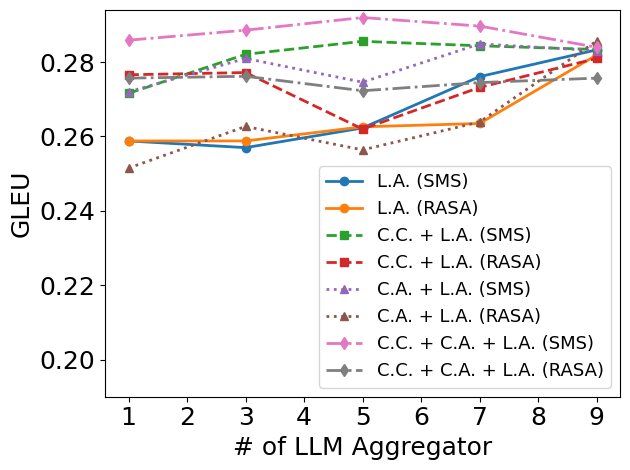

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.2588,0.2570,0.2623,0.2761,0.2833]
la_rasa = [0.2588,0.2588,0.2626,0.2635,0.2819]
cc_la_sms = [0.2716,0.2821,0.2856,0.2844,0.2834]
cc_la_rasa = [0.2766,0.2772,0.2620,0.2732,0.2810]
ca_la_sms = [0.2720,0.2810,0.2746,0.2849,0.2831]
ca_la_rasa = [0.2515,0.2627,0.2564,0.2639,0.2857]
cc_ca_la_sms = [0.2859,0.2886,0.2920,0.2897,0.2840]
cc_ca_la_rasa = [0.2757,0.2762,0.2723,0.2745,0.2757]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.19, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('GLEU', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('GLUE_Diff_Num_LLMAgg_J1_Gemini.pdf')

# Show the plot (optional)
plt.show()


#### J1 METEOR

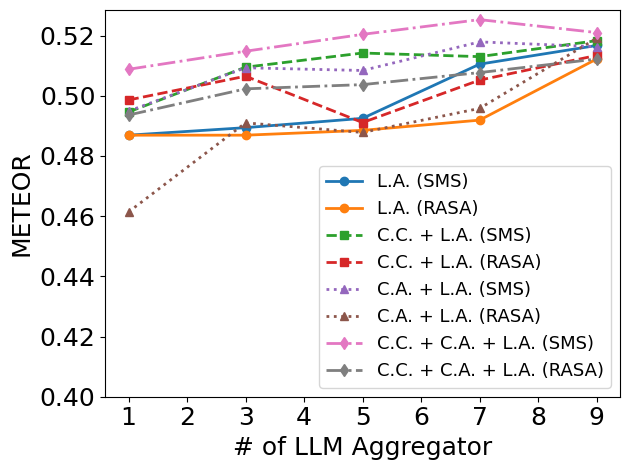

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.4869,0.4894,0.4925,0.5105,0.5167]
la_rasa = [0.4869,0.4869,0.4885,0.4919,0.5122]
cc_la_sms = [0.4946,0.5095,0.5142,0.5130,0.5183]
cc_la_rasa = [0.4986,0.5065,0.4911,0.5052,0.5134]
ca_la_sms = [0.4949,0.5093,0.5084,0.5179,0.5163]
ca_la_rasa = [0.4614,0.4910,0.4878,0.4958,0.5191]
cc_ca_la_sms = [0.5088,0.5148,0.5204,0.5253,0.5210]
cc_ca_la_rasa = [0.4936,0.5023,0.5037,0.5077,0.5122]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.40, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('METEOR', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('METEOR_Diff_Num_LLMAgg_J1_Gemini.pdf')

# Show the plot (optional)
plt.show()

#### J1 Embedding

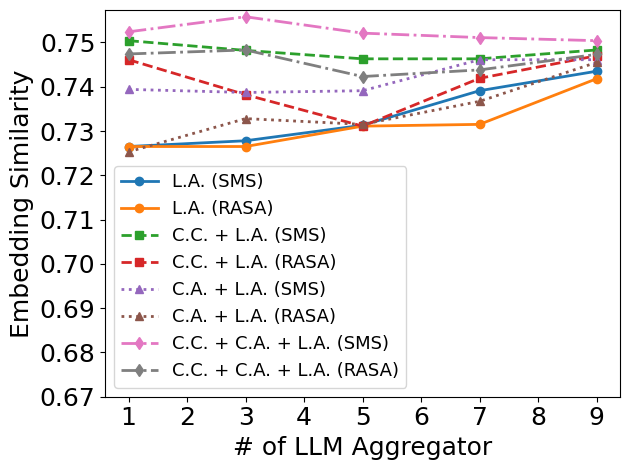

In [ ]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.7265,0.7278,0.7313,0.7391,0.7435]
la_rasa = [0.7265,0.7265,0.7311,0.7315,0.7418]
cc_la_sms = [0.7504,0.7482,0.7463,0.7463,0.7483]
cc_la_rasa = [0.7461,0.7382,0.7311,0.7419,0.7470]
ca_la_sms = [0.7394,0.7387,0.7391,0.7461,0.7461]
ca_la_rasa = [0.7253,0.7328,0.7315,0.7367,0.7455]
cc_ca_la_sms = [0.7524,0.7558,0.7521,0.7511,0.7504]
cc_ca_la_rasa = [0.7474,0.7483,0.7423,0.7438,0.7473]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.67, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('Embedding Similarity', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('EmbedSim_Diff_Num_LLMAgg_J1_Gemini.pdf')

# Show the plot (optional)
plt.show()

#### T1 GLUE

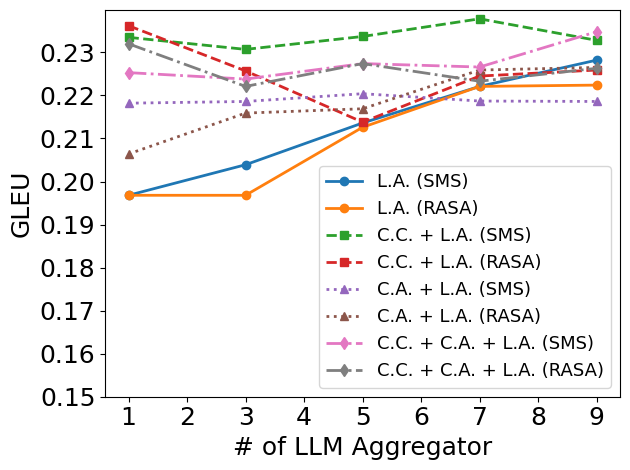

In [31]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.1968,0.2039,0.2136,0.2221,0.2282]
la_rasa = [0.1968,0.1968,0.2126,0.2221,0.2224]
cc_la_sms = [0.2335,0.2307,0.2337,0.2378,0.2328]
cc_la_rasa = [0.2362,0.2257,0.2138,0.2245,0.2259]
ca_la_sms = [0.2182,0.2186,0.2204,0.2187,0.2186]
ca_la_rasa = [0.2064,0.2159,0.2169,0.2259,0.2265]
cc_ca_la_sms = [0.2253,0.2238,0.2274,0.2266,0.2348]
cc_ca_la_rasa = [0.2320,0.2221,0.2274,0.2233,0.2263]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.15, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('GLEU', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('GLUE_Diff_Num_LLMAgg_T1_Gemini.pdf')

# Show the plot (optional)
plt.show()


#### T1 METEOR

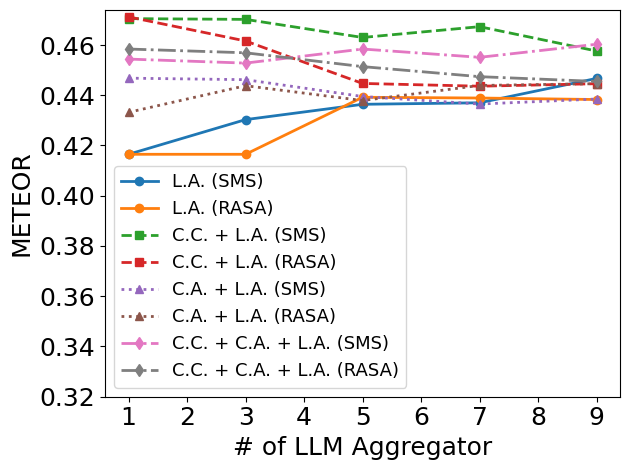

In [32]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.4165,0.4303,0.4364,0.4370,0.4467]
la_rasa = [0.4165,0.4165,0.4392,0.4389,0.4383]
cc_la_sms = [0.4705,0.4702,0.4630,0.4673,0.4576]
cc_la_rasa = [0.4712,0.4616,0.4447,0.4436,0.4446]
ca_la_sms = [0.4468,0.4462,0.4395,0.4365,0.4385]
ca_la_rasa = [0.4332,0.4438,0.4379,0.4439,0.4446]
cc_ca_la_sms = [0.4544,0.4528,0.4584,0.4551,0.4603]
cc_ca_la_rasa = [0.4584,0.4569,0.4514,0.4474,0.4455]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.32, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('METEOR', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('METEOR_Diff_Num_LLMAgg_T1_Gemini.pdf')

# Show the plot (optional)
plt.show()

#### T1 Embedding

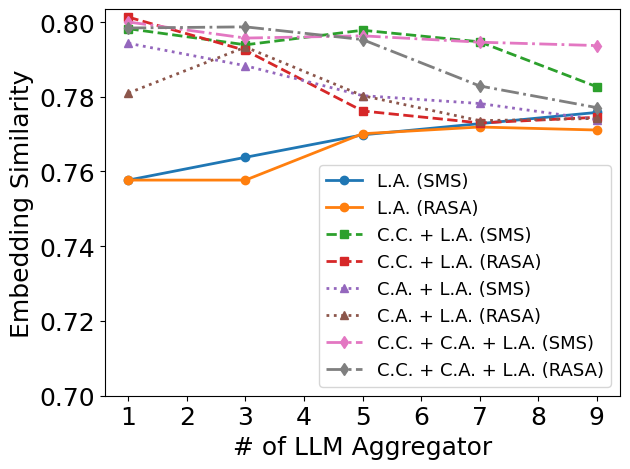

In [33]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.7577,0.7638,0.7698,0.7728,0.7758]
la_rasa = [0.7577,0.7577,0.7701,0.7719,0.7711]
cc_la_sms = [0.7982,0.7939,0.7978,0.7947,0.7827]
cc_la_rasa = [0.8013,0.7924,0.7762,0.7730,0.7745]
ca_la_sms = [0.7943,0.7883,0.7803,0.7782,0.7739]
ca_la_rasa = [0.7810,0.7933,0.7803,0.7736,0.7742]
cc_ca_la_sms = [0.8000,0.7957,0.7963,0.7946,0.7937]
cc_ca_la_rasa = [0.7984,0.7987,0.7953,0.7829,0.7771]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.70, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('Embedding Similarity', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('EmbedSim_Diff_Num_LLMAgg_T1_Gemini.pdf')

# Show the plot (optional)
plt.show()

#### T2 GLEU

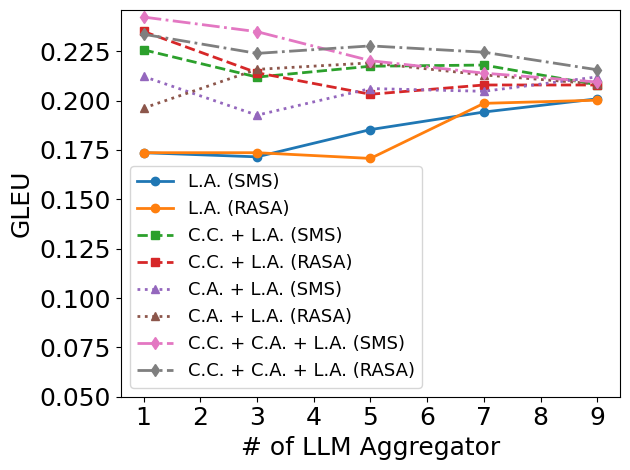

In [34]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.1736,0.1715,0.1853,0.1942,0.2009]
la_rasa = [0.1736,0.1736,0.1707,0.1986,0.2002]
cc_la_sms = [0.2257,0.2119,0.2174,0.2180,0.2080]
cc_la_rasa = [0.2350,0.2141,0.2032,0.2079,0.2079]
ca_la_sms = [0.2122,0.1926,0.2061,0.2047,0.2120]
ca_la_rasa = [0.1962,0.2158,0.2191,0.2130,0.2084]
cc_ca_la_sms = [0.2423,0.2349,0.2202,0.2139,0.2094]
cc_ca_la_rasa = [0.2336,0.2239,0.2277,0.2245,0.2156]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.05, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('GLEU', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('GLUE_Diff_Num_LLMAgg_T2_Gemini.pdf')

# Show the plot (optional)
plt.show()


#### T2 METEOR

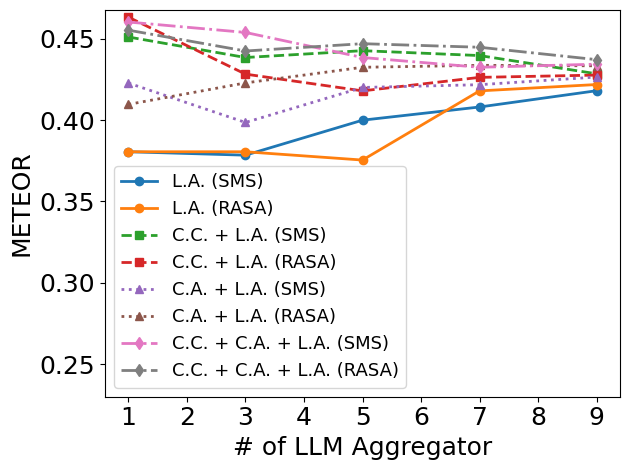

In [35]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.3805,0.3784,0.3999,0.4080,0.4180]
la_rasa = [0.3805,0.3805,0.3754,0.4179,0.4218]
cc_la_sms = [0.4510,0.4384,0.4426,0.4396,0.4284]
cc_la_rasa = [0.4632,0.4282,0.4179,0.4262,0.4276]
ca_la_sms = [0.4227,0.3985,0.4200,0.4217,0.4264]
ca_la_rasa = [0.4096,0.4228,0.4324,0.4336,0.4333]
cc_ca_la_sms = [0.4602,0.4538,0.4384,0.4324,0.4343]
cc_ca_la_rasa = [0.4552,0.4424,0.4469,0.4447,0.4371]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.23, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('METEOR', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('METEOR_Diff_Num_LLMAgg_T2_Gemini.pdf')

# Show the plot (optional)
plt.show()

#### T2 Embedding

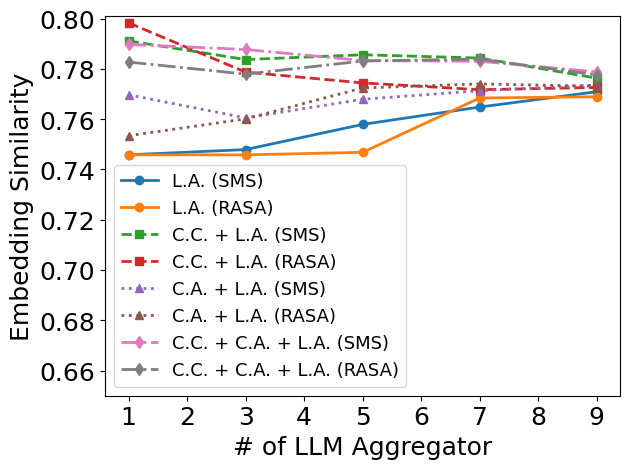

In [36]:
import matplotlib.pyplot as plt

# Given data
x_values = [1, 3, 5, 7, 9]

# Y values for different categories
la_sms = [0.7458,0.7479,0.7579,0.7648,0.7709]
la_rasa = [0.7458,0.7458,0.7468,0.7684,0.7689]
cc_la_sms = [0.7911,0.7837,0.7856,0.7843,0.7763]
cc_la_rasa = [0.7983,0.7787,0.7744,0.7717,0.7726]
ca_la_sms = [0.7697,0.7605,0.7679,0.7713,0.7736]
ca_la_rasa = [0.7534,0.7601,0.7724,0.7740,0.7731]
cc_ca_la_sms = [0.7897,0.7877,0.7833,0.7830,0.7788]
cc_ca_la_rasa = [0.7827,0.7779,0.7831,0.7839,0.7776]

# Create line plots for each category with specified markers and line styles
plt.plot(x_values, la_sms, label='L.A. (SMS)', marker='o', linestyle='-', linewidth=2)
plt.plot(x_values, la_rasa, label='L.A. (RASA)', marker='o', linestyle='-', linewidth=2)  # Same marker and line style as 'L.A. (SMS)'
plt.plot(x_values, cc_la_sms, label='C.C. + L.A. (SMS)', marker='s', linestyle='--', linewidth=2)
plt.plot(x_values, cc_la_rasa, label='C.C. + L.A. (RASA)', marker='s', linestyle='--', linewidth=2)  # Same marker and line style as 'C.C. + L.A. (SMS)'
plt.plot(x_values, ca_la_sms, label='C.A. + L.A. (SMS)', marker='^', linestyle=':', linewidth=2)
plt.plot(x_values, ca_la_rasa, label='C.A. + L.A. (RASA)', marker='^', linestyle=':', linewidth=2)  # Same marker and line style as 'C.A. + L.A. (SMS)'
plt.plot(x_values, cc_ca_la_sms, label='C.C. + C.A. + L.A. (SMS)', marker='d', linestyle='-.', linewidth=2)
plt.plot(x_values, cc_ca_la_rasa, label='C.C. + C.A. + L.A. (RASA)', marker='d', linestyle='-.', linewidth=2)  # Same marker and line style as 'C.C. + C.A. + L.A. (SMS)'

# Set y-axis scale
plt.ylim(0.65, None)

# Add labels and legend
plt.xlabel('# of LLM Aggregator', fontsize=18)
plt.ylabel('Embedding Similarity', fontsize=18)
plt.legend(fontsize=13)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Ensure tight layout
plt.tight_layout()

# Save the figure
plt.savefig('EmbedSim_Diff_Num_LLMAgg_T2_Gemini.pdf')

# Show the plot (optional)
plt.show()